# Surrogate Models
Julian Hsu

2025 March 23

The purpose of this script is to demonstrate surrogate models for predicting long-term outcomes based on intermediate, more quickly seen ones.

In [64]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [87]:
def dgp(n=None, num_surrogates=2):
    # Randomly assign treatment (0 or 1)
    treatment = np.random.choice(2,size=n)
    
    # Generate surrogate outcomes (medium-term impacts)
    surrogates= [] 
    for k in range(num_surrogates):
        surrogates.append( np.abs(np.random.normal(0, 2, size=n)) + treatment*2 )
    
    # Generate long-term outcome which is only a function of the surrogates, not the treatment effect
    long_term_outcome = 10 + np.abs( np.random.normal(0, 2, size=n) ) 
    for k in range(num_surrogates):        
        long_term_outcome += 4*surrogates[k]
    
    # Output a DataFrame for analysis
    output_df = pd.DataFrame(data={'w':treatment, 'y':long_term_outcome})
    for k in range(num_surrogates):
        output_df['s{0}'.format(k)]=surrogates[k]

    return output_df

def surrogate_model(data=None, surrogate_list=None):

    results_outcome = {}
    # Step 2: Estimate treatment impact on long-term outcome
    X_long_term = sm.add_constant(data["w"])
    model_long_term = sm.OLS(data["y"], X_long_term).fit()
    ## Record the "ground truth" impact of the treatment
    reg_y_w = model_long_term.params['w']
    # print(model_long_term.summary())
    results_outcome['y_reg_w'] = reg_y_w
    
    # Step 3: Estimate treatment impact on surrogate outcomes
    X_for_surrogate_results = sm.add_constant(data["w"])
    surrogate_coeff_results = []
    for s in surrogate_list:        
        model_surrogate = sm.OLS(data["{0}".format(s)], X_for_surrogate_results).fit()
        # print("\n**********\nImpact of treatment on surrogate {0}:".format(s))
        # print(model_surrogate.summary())
        surrogate_coeff_results.append([s, model_surrogate.params['w']])
        results_outcome['{0}_reg_w'.format(s)] = model_surrogate.params['w']
        
    # Step 4: Estimate impact of surrogate outcomes on long-term outcome
    X_surrogates = sm.add_constant(data[surrogate_list])
    model_surrogates = sm.OLS(data["y"], X_surrogates).fit()
    # print("\n****** ****** ****** ******\nImpact of surrogate outcomes on long-term outcome:")
    # print(model_surrogates.summary())
    reg_y_s = model_surrogates.params[surrogate_list]
    for s in surrogate_list:
        results_outcome['y_reg_{0}'.format(s)] = model_surrogates.params['{0}'.format(s)]
    # print('\n\n separate surrogate models for treatment and control groups:')
    # for wi in [0,1]:
    #     print('  for w={0}'.format(wi))
        # X_surrogates = sm.add_constant(data.loc[data.w==wi][surrogate_list])
        # model_surrogates = sm.OLS(data.loc[data.w==wi]["y"], X_surrogates).fit()
    #     print(model_surrogates.summary())
        
    return pd.DataFrame(index=[0],data=results_outcome)


Let's show that the surrogate model can predict the long-term impact.

In [91]:
df = dgp(n=1000, num_surrogates=1)

surrogate_model(data=df, surrogate_list=['s0'])

,y_reg_w,s0_reg_w,y_reg_s0
0,8.191533,2.050956,4.00242


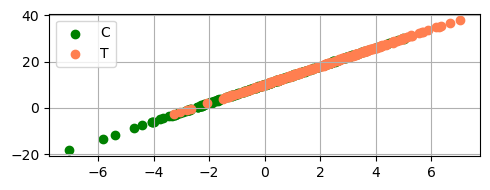

In [89]:
fig,ax = plt.subplots(figsize=(5,2) )
ax.scatter(df.loc[df.w==0]['s0'], df.loc[df.w==0]['y'], label='C', color='green')
ax.scatter(df.loc[df.w==1]['s0'], df.loc[df.w==1]['y'], label='T', color='coral')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

Let's show an illustrative graph where we track a trend in outcomes:
1. Spending during the experiment, and
2. Spending if we had extended the experiment by 10 more weeks.

In [101]:
s_results_collect = pd.DataFrame()
for r in range(100):
    df = dgp(n=1000, num_surrogates=1)
    s_results= surrogate_model(data=df, surrogate_list=['s0'])
    s_results_collect = pd.concat([s_results_collect, s_results])

C:\Users\hsuju\AppData\Local\Temp\ipykernel_9916\270662672.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


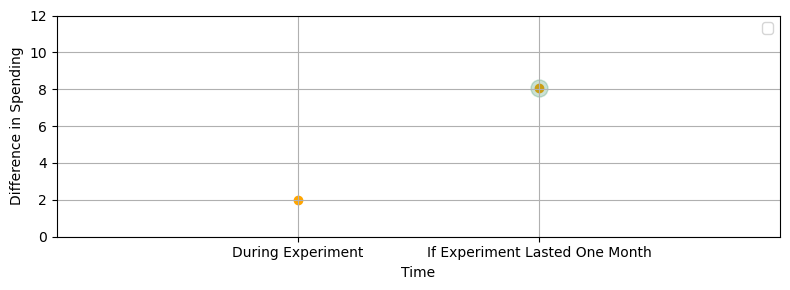

In [107]:
fig,ax = plt.subplots(figsize=(8,3))
ax.scatter([0,1], [s_results['s0_reg_w'].mean(), s_results['y_reg_w'].mean()], color='orange')
ax.scatter([1], [s_results['s0_reg_w'].mean()*s_results['y_reg_s0'].mean()], color='seagreen', alpha=0.25, s=150)
ax.grid()
ax.set_xticks([0,1])
ax.set_xticklabels(['During Experiment', 'If Experiment Lasted One Month'])
ax.set_xlabel('Time')
ax.set_ylabel('Difference in Spending')
ax.legend()
ax.set_xlim([-1,2])
ax.set_ylim([0,12])
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Spending')

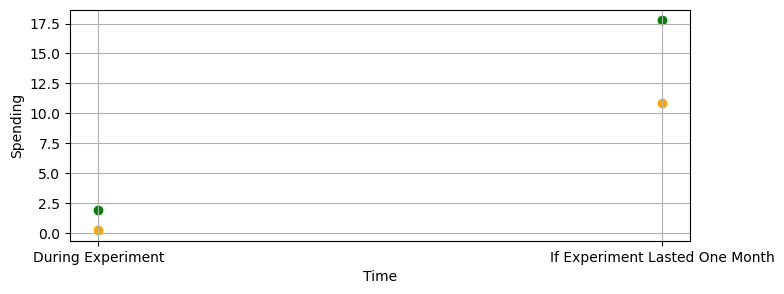

In [95]:
print('We could do a descriptive plot.')
fig,ax = plt.subplots(figsize=(8,3))
ax.scatter([0,1], df.loc[df.w==0][['s0','y']].mean(), color='orange', label='Control')
ax.scatter([0,1], df.loc[df.w==1][['s0','y']].mean(), color='green', label='Treatment')
ax.grid()
ax.set_xticks([0,1])
ax.set_xticklabels(['During Experiment', 'If Experiment Lasted One Month'])
ax.set_xlabel('Time')
ax.set_ylabel('Spending')
ax.legend()
plt.tight_layout()
plt.show()
